In [1]:
import pandas as pd
import os
import re
PROJ_ROOT = os.path.join(os.pardir)

# import gensim
import gensim .corpora as corpora
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import itertools
from itertools import dropwhile
import spacy # version 2.3.5
from spacy.lang.en.stop_words import STOP_WORDS
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
from collections import Counter, defaultdict
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
import numpy as np

In [2]:

url = 'https://raw.githubusercontent.com/datakind/Mar21-vaccine-uptake/main/data/twitter/twitter_data_cleaned.csv'
df = pd.read_csv(url)

users_path = os.path.join(PROJ_ROOT, 
                         'data',
                          'twitter_user.csv')

users = pd.read_csv(users_path)


In [3]:
df.head()

,tweet_id,created_at,full_text,geo,coordinates,place,retweet_count,favorite_count,possibly_sensitive,lang,user_id
0,1.364223e+18,2021-02-23 14:38:16+00:00,Here’s what's in the COVID relief package:\n \...,NaN,NaN,NaN,9160,38093,NOT FOUND,en,2.950125e+07
1,1.364381e+18,2021-02-24 01:07:52+00:00,Will the National Endowment for the Arts be he...,NaN,NaN,NaN,6131,18560,NOT FOUND,en,1.201671e+18
2,1.364610e+18,2021-02-24 16:14:15+00:00,"This is both anecdotal and early, but many lon...",NaN,NaN,NaN,5941,63174,NOT FOUND,en,3.842872e+07
3,1.364727e+18,2021-02-24 23:59:58+00:00,A Link to Professor Chossudovsky’s Analysis of...,NaN,NaN,NaN,1,0,False,en,2.192010e+09
4,1.364727e+18,2021-02-24 23:59:58+00:00,Children warned over hugging grandparents even...,NaN,NaN,NaN,0,2,False,en,2.868190e+09


In [4]:
users.head()

,user_id,user_location,user_verified,user_followers_count
0,29501253,"Burbank, CA",True,2931387
1,1201670995435646976,"Colorado, USA",True,557873
2,38428725,NaN,True,124131
3,2192010002,here & now 🇺🇸,False,2947
4,2868189989,Brighton UK and Bayonne France,False,2556


In [5]:
full_data = pd.merge(df, users,how='left', on='user_id')
full_data['created_at'] = pd.to_datetime(full_data['created_at']) # change the col to datetime
full_data=full_data[full_data.lang=='en']
print(full_data.lang.nunique())
full_data.head()

1


,tweet_id,created_at,full_text,geo,coordinates,place,retweet_count,favorite_count,possibly_sensitive,lang,user_id,user_location,user_verified,user_followers_count
0,1.364223e+18,2021-02-23 14:38:16+00:00,Here’s what's in the COVID relief package:\n \...,NaN,NaN,NaN,9160,38093,NOT FOUND,en,2.950125e+07,"Burbank, CA",True,2931387.0
1,1.364381e+18,2021-02-24 01:07:52+00:00,Will the National Endowment for the Arts be he...,NaN,NaN,NaN,6131,18560,NOT FOUND,en,1.201671e+18,"Colorado, USA",True,557873.0
2,1.364610e+18,2021-02-24 16:14:15+00:00,"This is both anecdotal and early, but many lon...",NaN,NaN,NaN,5941,63174,NOT FOUND,en,3.842872e+07,NaN,True,124131.0
3,1.364727e+18,2021-02-24 23:59:58+00:00,A Link to Professor Chossudovsky’s Analysis of...,NaN,NaN,NaN,1,0,False,en,2.192010e+09,here & now 🇺🇸,False,2947.0
4,1.364727e+18,2021-02-24 23:59:58+00:00,Children warned over hugging grandparents even...,NaN,NaN,NaN,0,2,False,en,2.868190e+09,Brighton UK and Bayonne France,False,2556.0


In [6]:
# dropping duplicate tweets. The same information by the same people. This will not
# include retweets, someone else can tweet the same text once.
full_data=full_data.drop_duplicates(subset=['full_text','user_id'])

In [7]:
nlp = spacy.load("en_core_web_lg") # import spacy model

In [8]:
# additional stop words to be removed from the vocabulary
# added the search terms from the github search page, with the exception of doses & pandemic
# 'rt' were added
# stop_words = {'covid','covid-19','covid19','carona','corona','carona virus','covid 19',
#               'caronavirus','coronavirus', 'vaccine','vaccinate', 'vaccination', 'virus',
#               'sarscov2','vax', 'vaccination', 'pfizer', 'moderna', 'vaccine', 'antivax',
#               'anti-vax','vaccinated',  '#covid19', 'johnson','j&j','rt','pandemic'}




In [9]:
sw_to_remove={'do', 'every', 'everyone', 'everywhere', 'few', 'get', 'give',
 'had', 'has', 'have' 'hundred' "n't", 'n‘t','n’t', 'serious','themselves','though',
 'yet','would','can','not','could','should'}
STOP_WORDS = STOP_WORDS-sw_to_remove

Removing some words that may have a lot of meaning turing topic modeling, when building ngrams when referring to the vaccine or the virus.

In [10]:
# add all of the tweets to one list
tweets = full_data.full_text.tolist()

## Clean the tweets

Attempt to change all the spelling variations of coronavirus to 'coronavirus'

In [11]:
# lowercase all the words
tweets= [word.lower() for word in tweets]


# # remove the '@' and '#' symbols
# tweets=[word.replace('@','').replace('#','') for word in tweets]

# remove the '#' symbol
# tweets=[word.replace('#','') for word in tweets]

# remove the '#' symbol and the '_' symbol, in the event an underscore is used for
#remove covid spelling variants
tweets=[word.replace('coronavaccine','covid-19 vaccine').replace('caronavac','covid-19 vaccine').replace('coronavaccination','covid-19 vaccine').replace('coronavirusvaccination','covid-19 vaccine').replace('coronavirusvaccine','coronavirus vaccine')  for word in tweets]
tweets=[word.replace('corona ','coronavirus').replace('carona','coronavirus').replace('corona virus','coronavirus') for word in tweets]
tweets=[word.replace('covid 19','coronavirus').replace('covid19','coronavirus').replace('covid-19','coronavirus') for word in tweets]
tweets=[word.replace('corona19','coronavirus') for word in tweets]
tweets=[word.replace('caronavirus','coronavirus').replace('covid','coronavirus')for word in tweets]
tweets=[word.replace('caronav ','coronavirus')for word in tweets]
# tweets=[word.replace('rt_','').replace('rt','').replace('ht','') for word in tweets]

In [12]:
# tweets=[word.replace('rt_','').replace('rt','').replace('ht','') for word in tweets]

tweets = [re.sub('(rt_)|\s(rt)\s','',tweet) for tweet in tweets]
tweets = [re.sub('(ht_)|\s(ht)\s','',tweet) for tweet in tweets]

### Remove hashtags

In [13]:


# create a list of all the # mentions
hash_counter=Counter(re.findall('(#\w+)',''.join(tweets)))
del_hash=hash_counter.copy() # create a copy

# filter for only mentions above 30 in the dataset
for key, count in dropwhile(lambda key_count : key_count[1]>=15,hash_counter.most_common()):
    del hash_counter[key]

# filter for mentions that are not >= 30    
del_hash = list(set(del_hash) - set(hash_counter))
if "#s" in del_hash:
    del_hash.remove("#s")
print('{} hashtags to be removed'.format(len(del_hash)))

removed_hashtags=[] # create a list to hold deleted  hashtags

# remove the hashtags from the tweets
# for each tweet
for tweet in tqdm(tweets):
    if any(word in tweet for word in del_hash): # if there is a word in the del hashtag list
        del_words=[] 
        for word in del_hash: # for each word in the deleted hashtag list
            if word in tweet: # if the word is in the tweet
                del_words.append(word) # add to the list of words to be deleted from tweet
        for word in del_words: # for each word in the words to be deleted in the tweet list
            tweet.replace(word,'') # replace with empty string
#         tweet.append(tweet) #add the updated tweet to the new new tweet list
        removed_hashtags.append(del_words)
    else:
        removed_hashtags.append(None)
    
# add the removed hashtags back into the dataframe
full_data['removed_hashtags']=removed_hashtags

16869 hashtags to be removed


  0%|          | 0/49838 [00:00<?, ?it/s]

### Remove url links

In [14]:


# create a list of all the # mentions
# url_counter=Counter(re.sub('(tps://[\w./]+)',''.join(tweets)))
# url_hash=url_counter.copy() # create a copy
# tweetsr=[re.sub('(tps://[\w./]+)','',tweet) for tweet in tweets]
# # filter for only mentions above 30 in the dataset
# for key, count in dropwhile(lambda key_count : key_count[1]>=15,hash_counter.most_common()):
#     del hash_counter[key]

# # filter for mentions that are not >= 30    
# del_hash = list(set(del_hash) - set(hash_counter))
# if "#s" in del_hash:
#     del_hash.remove("#s")
# print('{} hashtags to be removed'.format(len(del_hash)))

removed_urls=[] # create a list to hold deleted  hashtags
new_list=[]
# remove the hashtags from the tweets
# for each tweet
for tweet in tqdm(tweets):
    
    if len(re.findall('(tps://[\w./]+)|(https://[\w./]+)',tweet)) == 0:
        removed_urls.append(np.nan)
    else:
        removed_urls.append(re.findall('(tps://[\w./]+)|(https://[\w./]+)',tweet))
    
    new_list.append(re.sub('(tps://[\w./]+)|(https://[\w./]+)','',tweet))

    
# add the removed hashtags back into the dataframe
# full_data['urls']=removed_urls

tweets=new_list.copy()
del new_list

  0%|          | 0/49838 [00:00<?, ?it/s]

### Remove the @mentions

In [15]:
# create a list of all the @ mentions
at_counter=Counter([x for x in ' '.join(tweets).split(' ') if '@' in x])
del_ats1=at_counter.copy() # create a copy

# filter for only mentions above 30 in the dataset
for key, count in dropwhile(lambda key_count : key_count[1]>=30,at_counter.most_common()):
    del at_counter[key]

# filter for mentions that are not >= 30
# this list will be used in the spacy pipeline to remove these words
del_ats1 = list(set(del_ats1) - set(at_counter))

In [16]:
print(len(del_ats1),' mentions to be deleted') # number of @mentions to be deleted
print(len(at_counter),' mentions used {} times to be kept'.format(sum(list(at_counter.values())))) # of of @mentions to be kept

25736  mentions to be deleted
105  mentions used 7360 times to be kept


In [17]:
# removed_ats=[]
# for tweet in tqdm(tweets):
#     if any(word in tweet for word in del_ats): # if there is a word in the del hashtag list
#         del_words=[] 
#         for word in del_ats: # for each word in the deleted hashtag list
#             if word in tweet: # if the word is in the tweet
#                 del_ats.append(word) # add to the list of words to be deleted from tweet
#         for word in del_ats: # for each word in the words to be deleted in the tweet list
#             tweet.replace(word,'') # replace with empty string
#         filtered_list.append(tweet) #add the updated tweet to the new new tweet list
#         removed_ats.append(del_ats)
#     else:
#         removed_ats.append(None)

# filtered_list = []
# for word in tqdm(del_ats):
#     if any(word in tweet for word in del_ats):
#         del_words=list(set(del_ats).intersection(set(tweet)))
#         updated_tweet=[t_word for t_word in tweet if t_word not in del_words]
#         filtered_list.append(updated_tweet)
#     else:
#         filtered_list.append(tweet)

## Create and run spaCy pipeline

### Create nlp components to add to the pipeline

In [18]:
# # update the stop words
# nlp.Defaults.stop_words.update(stop_words) #update spacy stopwords to include additional words

# # udpate stopwords
# for word in STOP_WORDS:
#     lexeme = nlp.vocab[word]
#     lexeme.is_stop=True
    
# create lemmatize, remove_stopwords, list component spacy functions for the spacy pipeline
def lemmatize_pipe(doc):
    '''Function'''
    doc = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    doc = u' '.join(doc)
    
    return nlp.make_doc(doc)

def remove_stops(doc):
    '''function removes stopwords'''
    doc = [token.text for token in doc if nlp.vocab[token.text.lower()].is_stop!= True and token.is_punct != True and token.lemma_ not in STOP_WORDS]
    doc = u' '.join(doc)
    
    return nlp.make_doc(doc)

def remove_at_mentions(doc):
    '''Function to remove @mentions'''
    
    doc = [token.text if token.text not in del_ats1 else '' for token in doc ]
    doc = u' '.join(doc)
    
    return nlp.make_doc(doc)


def list_component(doc):
    '''This pipeline returns a list of tokens vs a spacy doc object'''
    tokens = [token.text for token in doc]
          
    return tokens

### add components to the pipeline

In [19]:
# add the pipes to the spacy pipeline
nlp.add_pipe(remove_stops, before='ner')
nlp.add_pipe(remove_at_mentions, last=True)
nlp.add_pipe(lemmatize_pipe, last=True)
nlp.add_pipe(list_component, last=True)

I'm curious if @ mentions should be moved altogether or just the @ symbol. The mentions may have a certain importance to them. Folks who tweet may swap out  word for an @mention instead.

On the other hand, i've seen a lot of retweets or tweets where an extremely large amount of people are mention, but do not give any context to what is being said. This could confuse certain models (ie. sentiment)

It might be interesting to leave these in to see who/which ner is mentioned the most


### Run the tweets through the pipeline

In [20]:
# run the tweets through the pipeline
processed_tweets = list(tqdm(nlp.pipe(tweets, disable=['tagger','parser','ner'])))

0it [00:00, ?it/s]

## Additional cleaning after the pipeline

Run some additional cleaning of the tokens after the spacy pipeline. The pipeline will have cleaned a lot of the text in the tweets making some @mentions and hashtags identifiable that were previously missed.

In [21]:
# some additional cleaning
processed_tweets=[[word.replace('\n','') for word in x] for x in processed_tweets]
processed_tweets=[[word.replace('\xa0  ','').replace('amp','') for word in x] for x in processed_tweets]
# remove the hashtag symbol from the hashtags that remain
processed_tweets=[[word.replace('#','') for word in x] for x in processed_tweets]

#remove all empty words from a tweet after all of the cleaning
processed_tweets=[[word.strip() for word in x if len(word.strip())>0] for x in processed_tweets]
# replace covid variations that were in hashtags
processed_tweets=[[word.replace('coronavaccine','covid-19 vaccine').replace('caronavac','covid-19 vaccine').replace('coronavaccination','covid-19 vaccine').replace('coronavirusvaccination','covid-19 vaccine').replace('coronavirusvaccine','coronavirus vaccine') for word in x] for x in processed_tweets]
processed_tweets=[[word.replace('corona ','coronavirus').replace('carona','coronavirus').replace('corona virus','coronavirus') for word in x] for x in processed_tweets]
processed_tweets=[[word.replace('covid 19','coronavirus').replace('covid19','coronavirus').replace('covid-19','coronavirus') for word in x] for x in processed_tweets]
processed_tweets=[[word.replace('corona19','coronavirus') for word in x] for x in processed_tweets]
processed_tweets=[[word.replace('caronavirus','coronavirus').replace('covid','coronavirus') for word in x] for x in processed_tweets]
processed_tweets=[[word.replace('caronav ','coronavirus') for word in x] for x in processed_tweets]


remove @ mentions that remained

In [22]:
# find @ mentions that remained
at_counter=Counter([x for twt in processed_tweets for x in twt if '@' in x])
del_ats2=at_counter.copy()
for key, count in dropwhile(lambda key_count : key_count[1]>=30,at_counter.most_common()):
    del at_counter[key]

del_ats2 = set(del_ats2) - set(at_counter)


In [23]:
# remove @ mentions that were used less than 30 times
filtered_list = []
for tweet in tqdm(processed_tweets):
    if any(word in tweet for word in del_ats2):
        del_words=list(set(del_ats2).intersection(set(tweet)))
        updated_tweet=[t_word for t_word in tweet if t_word not in del_words]
        filtered_list.append(updated_tweet)
    else:
        filtered_list.append(tweet)

processed_tweets = filtered_list.copy()
del filtered_list

# remove the hashtag symbol from the hashtags that remain
# processed_tweets=[[word.replace('@','') for word in x] for x in processed_tweets]

  0%|          | 0/49838 [00:00<?, ?it/s]

In [24]:
# hash_counter=Counter([x for twt in processed_tweets for x in twt if '#' in x])
# del_hash=hash_counter.copy() # create a copy
#filter for only mentions above 30 in the dataset
# for key, count in dropwhile(lambda key_count : key_count[1]>=15,hash_counter.most_common()):
#     del hash_counter[key]

# filter for mentions that are not >= 30    
# del_hash = set(del_hash) - set(hash_counter)

# # create a list of all the @ mentions
# hash_counter=Counter([x for x in ' '.join(tweets).split(' ') if '#' in x])
# del_hash=hash_counter.copy() # create a copy
# #filter for only mentions above 30 in the dataset
# for key, count in dropwhile(lambda key_count : key_count[1]>=15,hash_counter.most_common()):
#     del hash_counter[key]

# # filter for mentions that are not >= 30    
# del_hash = set(del_hash) - set(hash_counter)

In [25]:
len(processed_tweets)

49838

## Find n-grams in the tweets
All of n-grams from 1 to 6 are processed, each with a cutoff

In [26]:
# create ngrams with gensim
# min_count arbitrarily picked
bigram = Phrases(tqdm(processed_tweets), min_count = 20)
trigram = Phrases(tqdm(bigram[processed_tweets]), min_count=10)
qgram = Phrases(tqdm(trigram[processed_tweets]), min_count=10)
fgram = Phrases(tqdm(qgram[processed_tweets]),min_count=10)
sgram = Phrases(tqdm(fgram[processed_tweets]),min_count=10)

bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)
qgram_mod = Phraser(qgram)
fgram_mod = Phraser(fgram)
sgram_mod = Phraser(sgram)

def create_n_grams(text):
    '''Function that takes in text and returns the different ngrams'''
    return sgram_mod[fgram_mod[qgram_mod[trigram_mod[bigram_mod[text]]]]]

  0%|          | 0/49838 [00:00<?, ?it/s]

  0%|          | 0/49838 [00:00<?, ?it/s]

  0%|          | 0/49838 [00:00<?, ?it/s]

  0%|          | 0/49838 [00:00<?, ?it/s]

  0%|          | 0/49838 [00:00<?, ?it/s]

In [27]:
#create a list of tokens including ngrams for each response
all_tokens = [create_n_grams(doc) for doc in tqdm(processed_tweets)] 

  0%|          | 0/49838 [00:00<?, ?it/s]

In [28]:
len(processed_tweets)

49838

In [29]:
# remove empty tweets, and remove tweets less than 3 words long
print(len([x for x in all_tokens if len(x) <3]),' empty tweets after cleaning')
keep_inx=[i for i,x in enumerate(all_tokens) if len(x) >= 3]

full_data.reset_index(inplace=True,drop=True)

keep_inx=full_data.index.isin(keep_inx)


full_data=full_data.iloc[keep_inx]


all_tokens = [x for x in all_tokens if len(x) >= 3]
print(len(all_tokens))
print(full_data.shape[0])
assert len(all_tokens)== full_data.shape[0], 'The list of tokens and the dataframe should be equal'


653  empty tweets after cleaning
49185
49185


## Create gensim dictionary, corpus, and flattened out list of all the tokens in all tweets

In [30]:
# number of tweets to be dropped
print(full_data.duplicated(['full_text']).sum(),' tweets dropped')

# find the indicies of the duplicates to be deleted
full_data.reset_index(inplace=True,drop=True)
to_del_keys=full_data[full_data.duplicated(['full_text','user_id']).values].index
#remove all duplicates tweets
full_data=full_data.drop_duplicates(['full_text','user_id'])
# use the indicies to delete the tokenized tweets
for i in reversed(to_del_keys):
    del all_tokens[i]
# check that the lengths of the dataset and the processed tweets are the same
print(full_data.shape[0])
print(len(all_tokens))
assert len(all_tokens)==len(full_data), 'The list of tokens and the dataframe should be equal'

1636  tweets dropped
49185
49185


In [31]:
# add tokens incl ngrams to dataset
full_data['tokens'] = all_tokens
full_data['tknst']=full_data.tokens.apply(lambda x:' '.join(x))
print('duplicates to drop: ',full_data.duplicated(['user_id','tknst']).sum())
full_data.reset_index(inplace=True,drop=True)
full_data=full_data.drop_duplicates(['user_id','tknst'])
full_data.drop('tknst',inplace=True,axis=1)
full_data.reset_index(inplace=True,drop=True)
all_tokens = list(full_data.tokens)

duplicates to drop:  1220


In [32]:
print(len(all_tokens),full_data.shape[0])

47965 47965


In [33]:
tweets_gdict= corpora.Dictionary(all_tokens) # create a gensim dictionary
corpus = [tweets_gdict.doc2bow(doc) for doc in all_tokens] # create a corpus from the dictionary

# create one long list of tokens ie. flatten out the all_tokens list of lists
texts = list(itertools.chain.from_iterable(all_tokens)) 

In [34]:
# save all of the files
to_save = {'all_tokens.pkl':all_tokens,'tweets_gdict.pkl':tweets_gdict,
           'corpus.pkl':corpus,'texts.pkl':texts, 'tweets.pkl':tweets,
           'processed_tweets.pkl':processed_tweets}

data_path = os.path.join(PROJ_ROOT, 
                         'data')
for name, obj in to_save.items():
    
    with open(data_path+'\\'+name, 'wb') as f:
        pickle.dump(obj, f)
    
del to_save

## Visualize n-grams

In [35]:
#create a dictionary of the most used ngrams (1, 2, 3, 4+)
all_ngrams={}
for i in range(0,4):
    
    if i == 4:
        common_words = Counter([x for x in texts if x.count('_')>=i]).most_common(10)
    else:
        common_words = Counter([x for x in texts if x.count('_')==i]).most_common(10)
    
    for l in common_words:
        w,c = l

    all_ngrams[i]=common_words

### Wrangle the data to visualize the n-grams

In [36]:
# set the index for the data to datetime
full_data = full_data.set_index('created_at')

In [37]:
# make sure the shapes of the tokens and the dataset are the same
assert len(all_tokens)==len(full_data), 'The list of tokens and the dataframe should be equal'

In [38]:
# create a list of diffent days in the dataset
date_ranges=pd.date_range(start=full_data.index.min(), end=full_data.index.max(), freq='D')
date_ranges=date_ranges.strftime('%m-%d-%Y') # reformat

# create a list of al the most common ngrams, top 10 for each ngram
top_ngrams = [words[0] for ngrams in all_ngrams.values() for words in ngrams]

# empty dictionary to hold number of ngrams for each date
ngram_by_date=defaultdict(list) 

for date in date_ranges:
    # subset the tweets for only that date from the original data
    tmp=full_data.loc[date].tokens.tolist() 
    # create one long list of words from all the tweets for that day
    tmp = [word for twt in tmp for word in twt] 
    # count the words
    cnts = Counter(tmp)
    
    # for each word in the top n_grams list
    # add into a dictionary with the date as the key and the
    # total count for that word as the value
    for w in top_ngrams:
        ngram_by_date[date].append(cnts.get(w,0))



The code above is used to create a dictionary with the top 10 words for each ngram length. It is limited to 10 to plot easier. 

It can be adjusted to create a dictionary / dataframe for all of the words in all the tweets. This way you can literally see how any word trends over time, not just the top **total** words

In [39]:
# create a dataframe from the dictionary
ngrams_by_date = pd.DataFrame.from_dict(ngram_by_date, orient='index', columns = top_ngrams)

In [40]:
# The top 10 ngrams
pprint(all_ngrams)

{0: [('coronavirus', 36289),
     ('vaccine', 25509),
     ('vaccinate', 6883),
     ('pandemic', 5878),
     ('people', 5465),
     ('virus', 5029),
     ('vaccination', 4820),
     ('dose', 4604),
     ('get', 4110),
     ('vax', 2980)],
 1: [('johnson_johnson', 989),
     ('pfizer_moderna', 746),
     ('anti_vax', 550),
     ('2_dose', 509),
     ('wear_mask', 507),
     ('fully_vaccinate', 445),
     ('million_dose', 405),
     ('coronavirus_19', 382),
     ('pfizer_biontech', 346),
     ('receive_dose', 338)],
 2: [('coronavirus_hoax_stop', 146),
     ('vaccine_dose_reach', 134),
     ('risk_defeat_coronavirus', 133),
     ('vaccine_nationalism_world', 132),
     ('people_live_economy', 132),
     ('vaccine_december_2019', 120),
     ('pfizer_biontech_moderna', 105),
     ('@mark_j_harper', 97),
     ('baric_review_moderna', 86),
     ('@pfizer_@moderna_tx', 83)],
 3: [('white_republicans_large_group', 164),
     ('rt_black_vax_hesitancy', 163),
     ('headline_reluctant_group_far

### Plot ngrams over time

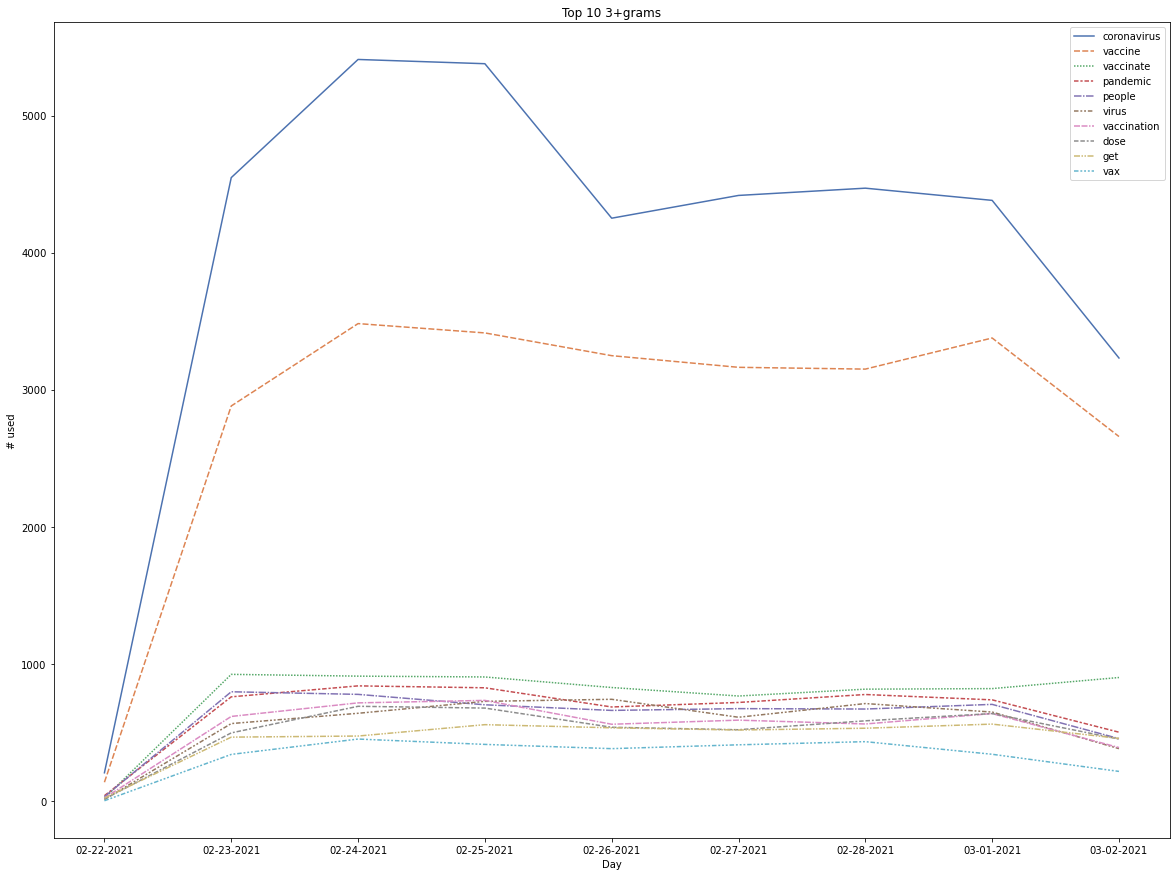

In [41]:
# plot the ngrams over time
# use the number '_' to decide which ngrams to show, ie. 1=bigrams  'j_j'
to_drop=[x for x in ngrams_by_date.columns if x.count('_') !=0]

fig, ax = plt.subplots(figsize=(20,15))
_=sns.lineplot(data=ngrams_by_date.drop(to_drop, axis=1), palette='deep')

plt.xlabel('Day')
plt.ylabel('# used')
plt.title('Top 10 3+grams')
plt.show()
# plt.savefig('3+gram.png', bbox_inches='tight')


Because the tweets were gathered by search terms such as 'covid' (and spelling variations) and 'vaccine' (and variations) those are the top words used. These can be taken out before doing the analysis to get a better view on search terms (or filter them out before displaying a visualization).

The terms were left in to help with modeling

In [42]:
## Save updated dataset

In [43]:
full_data.to_csv(data_path+'\\'+'temp_full_data.csv')